In [2]:
# Load dataset & basic sanity checks

import pandas as pd
import numpy as np
from pathlib import Path
pd.options.display.max_columns = 120

# file path
path = Path("data/taxi_fare.csv")   # change if needed

if not path.exists():
    raise FileNotFoundError(f"{path} not found. Put your CSV in data/ or update path.")


In [3]:
# parse dates (adjust names if your file differs)
date_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
df = pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# quick overview
print("Shape:", df.shape)
display(df.head(5))
print("\nColumn dtypes:")
print(df.dtypes)

Shape: (212345, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80



Column dtypes:
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
pickup_longitude                float64
pickup_latitude                 float64
RatecodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object


In [4]:
# missing values (top 20)

missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(20))


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [5]:
# duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [6]:
# required columns check (project spec)
required_cols = ["VendorID","tpep_pickup_datetime","tpep_dropoff_datetime","passenger_count",
                 "pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude",
                 "payment_type","fare_amount","extra","mta_tax","tip_amount","tolls_amount",
                 "improvement_surcharge","total_amount"]
missing_required = [c for c in required_cols if c not in df.columns]
print("Missing required columns:", missing_required)

Missing required columns: []


In [7]:
# basic stats
display(df[["fare_amount","tip_amount","total_amount","passenger_count"]].describe().T)

,count,mean,std,min,25%,50%,75%,max
fare_amount,212345.0,12.665588,10.875584,-52.0,6.5,9.50,14.50,819.50
tip_amount,212345.0,1.809357,2.507419,-2.7,0.0,1.35,2.36,218.95
total_amount,212345.0,15.649355,13.592129,-52.8,8.3,11.62,17.16,832.80
passenger_count,212345.0,1.766493,1.469647,0.0,1.0,1.00,2.00,6.00


In [8]:
# make a quick duration column for sanity checks
df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60.0
display(df["trip_duration_min"].describe())

count    212345.000000
mean         16.149813
std          56.178587
min       -7174.583333
25%           6.716667
50%          11.266667
75%          18.300000
max        1439.383333
Name: trip_duration_min, dtype: float64

In [9]:
# suspicious financials
print("total_amount <= 0:", (df["total_amount"] <= 0).sum())
print("fare_amount <= 0:", (df["fare_amount"] <= 0).sum())


total_amount <= 0: 144
fare_amount <= 0: 156


In [10]:
print("Before cleaning:", df.shape)
df_cleaned = df.copy()

Before cleaning: (212345, 19)


In [11]:
# Remove invalid fares, tips, totals

df_cleaned = df_cleaned[(df_cleaned['fare_amount'] > 0) &
                        (df_cleaned['total_amount'] > 0) &
                        (df_cleaned['tip_amount'] >= 0)]

# Remove invalid passenger counts
df_cleaned = df_cleaned[df_cleaned['passenger_count'] > 0]

# Remove invalid trip durations
df_cleaned = df_cleaned[df_cleaned['trip_duration_min'] > 0]

In [12]:
print("After cleaning:", df_cleaned.shape)

After cleaning: (212055, 19)


In [13]:
# Check if any invalids remain
print("fare_amount <= 0:", (df_cleaned['fare_amount'] <= 0).sum())
print("total_amount <= 0:", (df_cleaned['total_amount'] <= 0).sum())
print("tip_amount < 0:", (df_cleaned['tip_amount'] < 0).sum())
print("passenger_count == 0:", (df_cleaned['passenger_count'] == 0).sum())
print("trip_duration_min <= 0:", (df_cleaned['trip_duration_min'] <= 0).sum())


fare_amount <= 0: 0
total_amount <= 0: 0
tip_amount < 0: 0
passenger_count == 0: 0
trip_duration_min <= 0: 0


In [14]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Fare Amount
fare_low, fare_high = detect_outliers_iqr(df_cleaned, 'fare_amount')
print("Fare bounds:", fare_low, fare_high)

# Tip Amount
tip_low, tip_high = detect_outliers_iqr(df_cleaned, 'tip_amount')
print("Tip bounds:", tip_low, tip_high)

# Total Amount
total_low, total_high = detect_outliers_iqr(df_cleaned, 'total_amount')
print("Total bounds:", total_low, total_high)

# Trip Duration
trip_low, trip_high = detect_outliers_iqr(df_cleaned, 'trip_duration_min')
print("Trip Duration bounds:", trip_low, trip_high)


Fare bounds: -5.5 26.5
Tip bounds: -3.54 5.9
Total bounds: -5.124999999999998 30.674999999999997
Trip Duration bounds: -10.641666666666666 35.69166666666666


In [15]:
import numpy as np

# Haversine distance function (in kilometers)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat/2)**2 + np.cos(lat1_rad)*np.cos(lat2_rad)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply to dataset
df_cleaned['trip_distance'] = haversine_distance(
    df_cleaned['pickup_latitude'],
    df_cleaned['pickup_longitude'],
    df_cleaned['dropoff_latitude'],
    df_cleaned['dropoff_longitude']
)

# Quick check
df_cleaned[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','trip_distance']].head()


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance
0,40.765152,-73.976746,40.746128,-74.004265,3.138096
1,40.767925,-73.983482,40.733166,-74.005943,4.303331
2,40.644810,-73.782021,40.675770,-73.974541,16.600142
7,40.647758,-73.788773,40.712345,-73.829208,7.950066
8,40.764641,-73.958221,40.762901,-73.967896,0.837395


In [16]:
df_cleaned['trip_distance'].describe()

count    212055.000000
mean         19.960728
std         380.675716
min           0.000000
25%           1.156021
50%           1.937574
75%           3.560921
max        8713.463111
Name: trip_distance, dtype: float64

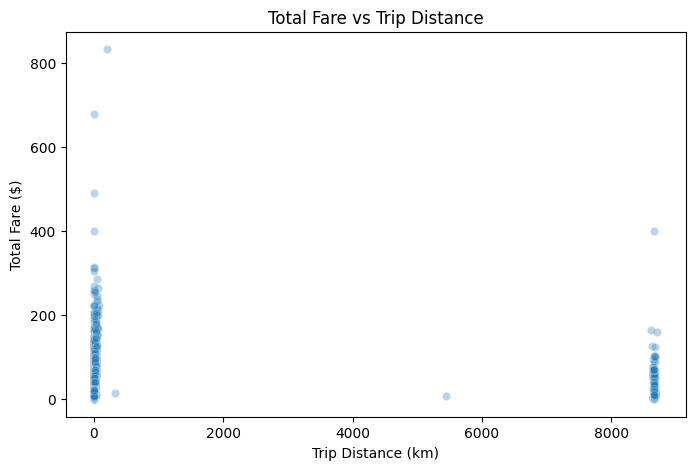

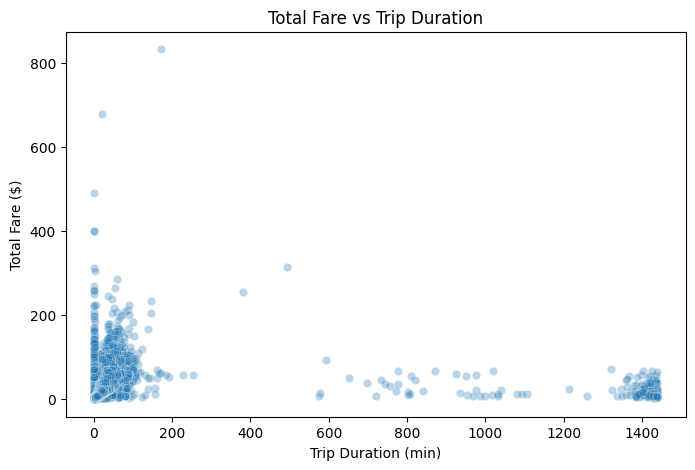

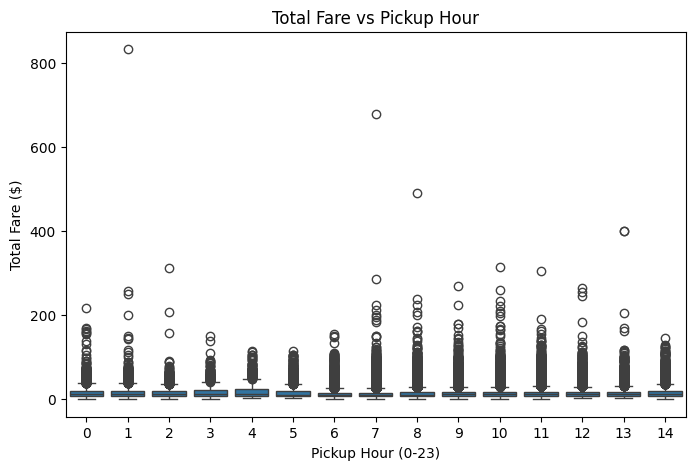

In [17]:
# full analysis of high fares vs distance, duration, and time of day


# Convert pickup datetime to local time if needed (assuming already cleaned)
df_cleaned['pickup_hour'] = df_cleaned['tpep_pickup_datetime'].dt.hour
df_cleaned['am_pm'] = df_cleaned['pickup_hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

df_cleaned[['total_amount','fare_amount','tip_amount','trip_distance','trip_duration_min','pickup_hour']].corr()

import matplotlib.pyplot as plt
import seaborn as sns

# Total Fare vs Distance
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_distance', y='total_amount', data=df_cleaned, alpha=0.3)
plt.title("Total Fare vs Trip Distance")
plt.xlabel("Trip Distance (km)")
plt.ylabel("Total Fare ($)")
plt.show()

# Total Fare vs Duration
plt.figure(figsize=(8,5))
sns.scatterplot(x='trip_duration_min', y='total_amount', data=df_cleaned, alpha=0.3)
plt.title("Total Fare vs Trip Duration")
plt.xlabel("Trip Duration (min)")
plt.ylabel("Total Fare ($)")
plt.show()

# Total Fare vs Pickup Hour
plt.figure(figsize=(8,5))
sns.boxplot(x='pickup_hour', y='total_amount', data=df_cleaned)
plt.title("Total Fare vs Pickup Hour")
plt.xlabel("Pickup Hour (0-23)")
plt.ylabel("Total Fare ($)")
plt.show()



1. High fares are NOT explained by distance or duration -> they are anomalies or outliers.
2. Time of day doesn’t contribute either -> late-night or early-morning rides are fine, but they don’t explain $800+ fares.
3. No linear relationship -> scatterplots show lots of points above normal range.
4. Boxplots confirm extreme fares -> many points are far above the whiskers (outliers).



In [18]:
corr_extra_total = df_cleaned[['extra','total_amount']].corr()
print("Correlation between extra charges and total fare:\n", corr_extra_total)

Correlation between extra charges and total fare:
                  extra  total_amount
extra         1.000000      0.005797
total_amount  0.005797      1.000000


- Extra charges do not explain high total fares.
- High fares are not coming from surcharges; they are likely anomalous data points.

In [19]:
# Restricting Long and Lat within the city

In [20]:
df_cleaned = df_cleaned[
    (df_cleaned['pickup_latitude'].between(40.5, 40.9)) &
    (df_cleaned['pickup_longitude'].between(-74.25, -73.7)) &
    (df_cleaned['dropoff_latitude'].between(40.5, 40.9)) &
    (df_cleaned['dropoff_longitude'].between(-74.25, -73.7))
].copy()

In [21]:
# Make a copy to avoid modifying original cleaned data
df_final = df_cleaned.copy()

# Apply thresholds based on fare, tip, total, duration, and passengers
df_final = df_final[
    (df_final['fare_amount'] >= 1) & (df_final['fare_amount'] <= 200) &
    (df_final['tip_amount'] >= 0) & (df_final['tip_amount'] <= 50) &
    (df_final['total_amount'] >= 1) & (df_final['total_amount'] <= 250) &
    (df_final['trip_duration_min'] >= 1) & (df_final['trip_duration_min'] <= 360) &
    (df_final['passenger_count'] >= 1) & (df_final['passenger_count'] <= 6)
].copy()

# reset index
df_final.reset_index(drop=True, inplace=True)

In [22]:

# Quick sanity checks
print("Shape after final cleaning:", df_final.shape)
print("Fare min/max:", df_final['fare_amount'].min(), "/", df_final['fare_amount'].max())
print("Total min/max:", df_final['total_amount'].min(), "/", df_final['total_amount'].max())
print("Tip min/max:", df_final['tip_amount'].min(), "/", df_final['tip_amount'].max())
print("Trip duration min/max:", df_final['trip_duration_min'].min(), "/", df_final['trip_duration_min'].max())
print("Passenger count min/max:", df_final['passenger_count'].min(), "/", df_final['passenger_count'].max())

Shape after final cleaning: (208024, 22)
Fare min/max: 1.1 / 200.0
Total min/max: 1.9 / 205.84
Tip min/max: 0.0 / 45.0
Trip duration min/max: 1.0 / 253.98333333333332
Passenger count min/max: 1 / 6


In [23]:
# Save the final cleaned dataframe to CSV
df_final.to_csv("data/tripfare_cleaned.csv", index=False)

print("Final cleaned dataset saved as 'tripfare_cleaned.csv'")


Final cleaned dataset saved as 'tripfare_cleaned.csv'
